# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory data analysis

## Review contents of datasets and confirm validity.

In [2]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio['difficulty_reward_ratio'] = portfolio['difficulty']/portfolio['reward']
portfolio = portfolio.fillna(0)

Portfolio is a simple dataset containing 10 rows corresponding to different offers sent out to users.
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [5]:
portfolio.groupby('offer_type')['difficulty_reward_ratio'].mean()

offer_type
bogo             1.000000
discount         4.083333
informational    0.000000
Name: difficulty_reward_ratio, dtype: float64

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isna().mean()
# profile dataset contains null values in income and gender columns

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [10]:
profile.duplicated().mean()

0.0

In [11]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [12]:
profile[profile['income'].isnull() | profile['gender'].isnull()]['age'].describe()
# it appears that rows containig null values all contain the nonsensical age of 118. It may be a bug or a default value for when nothing is entered, so I elect to remove all of these rows.

count    2175.0
mean      118.0
std         0.0
min       118.0
25%       118.0
50%       118.0
75%       118.0
max       118.0
Name: age, dtype: float64

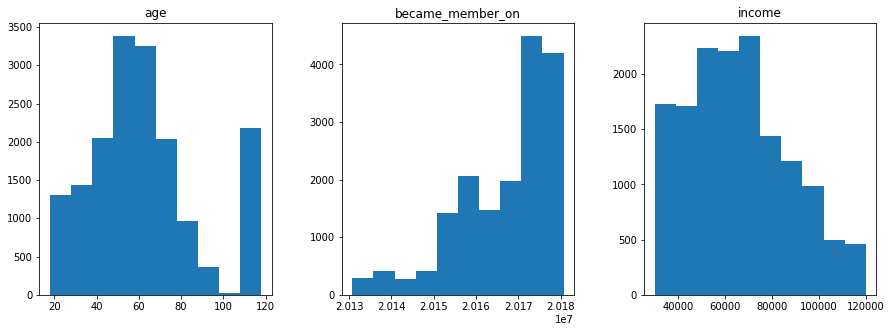

In [110]:
profile.hist(layout = (1, 3), grid = False, figsize=(15, 5));

Profile dataset contains demographic information of Starbucks offer app users.
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It has 17000 rows and there are some apparent problems with the dataset: 12.7% of rows have missing values for income and gender, and there are some dubious values for age (the maximum age in the dataset is 118). Fortunately, these are the same rows and to make my analysis easier I choose to remove these rows (because infering would be impossible and losing 12.7% entries in this case is not terrible).

In [16]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [17]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [18]:
transcript.shape

(306534, 4)

In [19]:
transcript.isna().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [20]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Transcript dataset contains 306534 rows representing events such as transaction, offer received, offer viewed and offer completed. It has no missing and no duplicate values.

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Data cleaning and feature engineering

My goals during data cleaning and feature engineering are to:
* infer or remove missing values, if any
* identify and remove/fix nonsensical values, if any
* process categorical values via label encoding and/or one hot encoding for later use in predictive models
* create new features if possible

I will also transform all ids which are provided as hashes to simple integers for easier and more efficient analysis and joins.

In [123]:
def id_transformer(df, column):
    '''
    Takes in dataframe and id column (containing hash), returns df with id as integer.
    '''
    le = preprocessing.LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])
    
    return df

### Portfolio

In [117]:
clean_portfolio = portfolio.copy()
clean_portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

In [125]:
clean_portfolio = id_transformer(clean_portfolio, 'offer_id')

In [93]:
portfolio_channels_one_hot = pd.get_dummies(clean_portfolio.channels.apply(pd.Series).stack()).sum(level=0)
clean_portfolio = clean_portfolio.drop('channels', axis = 1)
clean_portfolio = clean_portfolio.join(portfolio_channels_one_hot)

In [94]:
clean_portfolio['offer_type'] = clean_portfolio['offer_type'].astype('category')
clean_portfolio['offer_type_codes'] = clean_portfolio['offer_type'].cat.codes

In [95]:
clean_portfolio

,reward,difficulty,duration,offer_type,offer_id,difficulty_reward_ratio,email,mobile,social,web,offer_type_codes
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.000000,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.000000,1,1,1,1,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0.000000,1,1,0,1,2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.000000,1,1,0,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4.000000,1,0,0,1,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,2.333333,1,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,5.000000,1,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.000000,1,1,1,0,2
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.000000,1,1,1,1,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,5.000000,1,1,0,1,1


### Profile

In [96]:
clean_profile = profile.copy().dropna()
clean_profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [127]:
clean_profile = id_transformer(clean_profile, 'customer_id')

In [97]:
clean_profile['age_bin'] = pd.cut(clean_profile['age'], bins = [17, 20, 25, 35, 60, 102], labels=['teen', 'young', 'young-adult', 'adult', 'elderly'])
clean_profile.drop('age', axis = 1, inplace = True)

In [98]:
clean_profile['income_bin'] = pd.cut(clean_profile['income'], bins = [29999, 49000, 64000, 80000, 120001], labels = ['Q1_income', 'Q2_income', 'Q3_income', 'Q4_income'])
clean_profile.drop('income', axis = 1, inplace = True)

In [99]:
clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format = '%Y%m%d')
clean_profile['member_on_year'] = clean_profile['became_member_on'].dt.year

In [100]:
clean_profile['income_bin'] = clean_profile['income_bin'].astype('category')
clean_profile['income_bin_codes'] = clean_profile['income_bin'].cat.codes

In [101]:
clean_profile['gender'] = clean_profile['gender'].astype('category')
clean_profile['gender_codes'] = clean_profile['gender'].cat.codes

In [102]:
clean_profile['age_bin'] = clean_profile['age_bin'].astype('category')
clean_profile['age_bin_codes'] = clean_profile['age_bin'].cat.codes

In [103]:
clean_profile.head()

,gender,customer_id,became_member_on,age_bin,income_bin,member_on_year,income_bin_codes,gender_codes,age_bin_codes
1,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15,adult,Q4_income,2017,3,0,3
3,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,elderly,Q4_income,2017,3,0,4
5,M,e2127556f4f64592b11af22de27a7932,2018-04-26,elderly,Q3_income,2018,2,1,4
8,M,389bc3fa690240e798340f5a15918d5c,2018-02-09,elderly,Q2_income,2018,1,1,4
12,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,adult,Q2_income,2017,1,1,3


### Transcript

In [154]:
clean_transcript = transcript.copy()

In [139]:
def unpack(df, column, fillna=None):
    '''
    Takes dataframe, column containing a dictionary and fillna param; returns dataframe with new columns filled with dictionary values.
    '''
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

# taken from https://codereview.stackexchange.com/questions/93923/extracting-contents-of-dictionary-contained-in-pandas-dataframe-to-make-new-data

In [155]:
clean_transcript = unpack(clean_transcript, 'value', None)

# this works okay, but creates two columns - 'offer id' and 'offer_id', which I need to coalesce because they contain the same information

In [156]:
clean_transcript['offer'] = df['offer id'].combine_first(df['offer_id'])
clean_transcript.drop(['offer id', 'offer_id'], axis = 1, inplace = True)
clean_transcript.rename(columns = {'offer':'offer_id'}, inplace = True)
clean_transcript['offer_id'] = clean_transcript['offer_id'].astype('str')

In [148]:
clean_transcript = id_transformer(clean_transcript, 'offer_id')

In [151]:
clean_transcript.rename(columns = {'person':'customer_id'}, inplace = True)
clean_transcript = id_transformer(clean_transcript, 'customer_id')

In [149]:
clean_transcript['event'] = clean_transcript['event'].astype('category')
clean_transcript['event_codes'] = clean_transcript['event'].cat.codes

In [152]:
clean_transcript.head(10)

,customer_id,event,time,amount,reward,offer_id,event_codes
0,7996,offer received,0,NaN,NaN,6,1
1,10735,offer received,0,NaN,NaN,0,1
2,15043,offer received,0,NaN,NaN,2,1
3,9524,offer received,0,NaN,NaN,9,1
4,6939,offer received,0,NaN,NaN,4,1
5,3728,offer received,0,NaN,NaN,8,1
6,13108,offer received,0,NaN,NaN,1,1
7,3059,offer received,0,NaN,NaN,3,1
8,11410,offer received,0,NaN,NaN,0,1
9,3274,offer received,0,NaN,NaN,0,1


# Analysis

# Model